# Task IX. Kolmogorov-Arnold Network (KAN)
Implementation of a classical Kolmogorov-Arnold Network based on the Kolmogorov-Arnold representation theorem with b-splines applied to the MNIST dataset. 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [35]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = MNIST(root='./data', train=True, download=True, transform=transform)
test_data = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

In [36]:
class BSplineActivation(nn.Module):
    def __init__(self, num_bases=10, degree=3, input_dim=784):
        super().__init__()
        self.num_bases = num_bases
        self.degree = degree
        self.input_dim = input_dim

        self.knots = torch.linspace(0, 1, num_bases + degree + 1)
        self.register_buffer("knots_buffer", self.knots)

        self.coeffs = nn.Parameter(torch.randn(input_dim, num_bases))

    def forward(self, x):
        x = (x - x.min()) / (x.max() - x.min() + 1e-6)
        B = self.bspline_basis(x)  # (batch, input_dim, num_bases)
        B = B.squeeze()
        out = torch.einsum('bik,ik->bi', B, self.coeffs)  # (batch, input_dim)
        return out

    def bspline_basis(self, x):
        batch_size, input_dim = x.shape
        x = x.unsqueeze(-1)  # (batch, input_dim, 1)
        knots = self.knots_buffer
        degree = self.degree
        num_bases = self.num_bases

        B = []
        for i in range(num_bases):
            left = knots[i]
            right = knots[i + 1]
            B.append(((x >= left) & (x < right)).float())
        B = torch.stack(B, dim=2)  # (batch, input_dim, num_bases)

        for d in range(1, degree + 1):
            B_new = []
            for i in range(num_bases):
                denom1 = knots[i + d] - knots[i]
                denom2 = knots[i + d + 1] - knots[i + 1]

                term1 = 0
                if denom1 > 0:
                    term1 = ((x.squeeze(-1) - knots[i]) / denom1).unsqueeze(-1) * B[:, :, i]

                term2 = 0
                if i + 1 < num_bases and denom2 > 0:
                    term2 = ((knots[i + d + 1] - x.squeeze(-1)) / denom2).unsqueeze(-1) * B[:, :, i + 1]

                B_new.append(term1 + term2)

            B = torch.stack(B_new, dim=2)

        return B

class BSplineKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784, 784)
        self.bkan = BSplineActivation(input_dim=784)
        self.linear2 = nn.Linear(784, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.bkan(x)
        x = self.linear2(x)
        return x


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BSplineKAN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")



Epoch 1, Loss: 0.2724
Epoch 2, Loss: 0.0962
Epoch 3, Loss: 0.0655
Epoch 4, Loss: 0.0387
Epoch 5, Loss: 0.0445
Epoch 6, Loss: 0.0261
Epoch 7, Loss: 0.0154
Epoch 8, Loss: 0.0093
Epoch 9, Loss: 0.0076
Epoch 10, Loss: 0.0085


In [38]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.12%


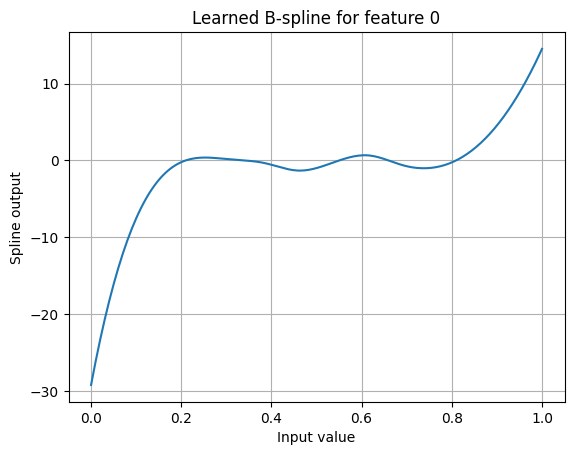

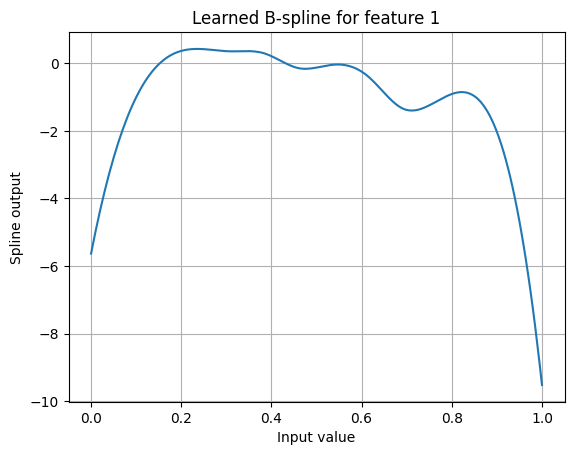

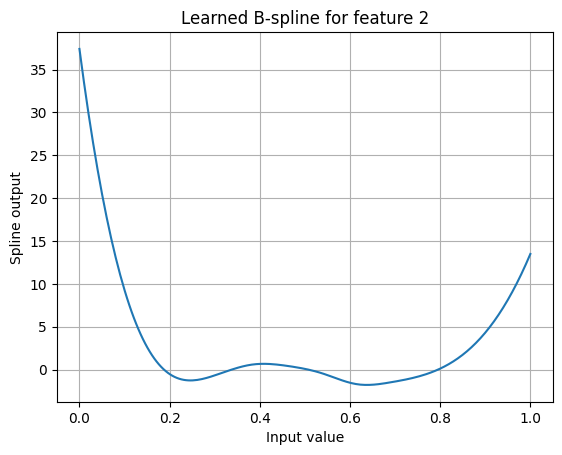

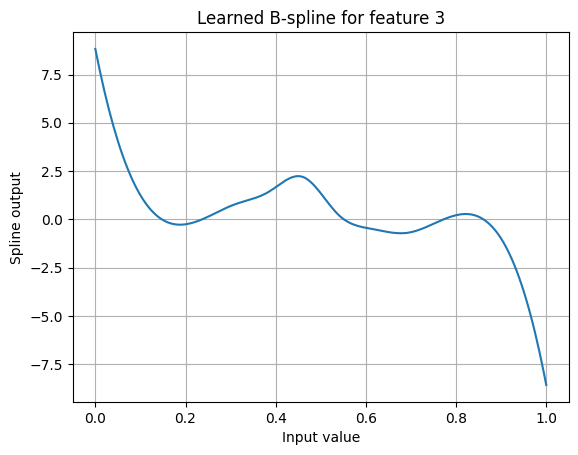

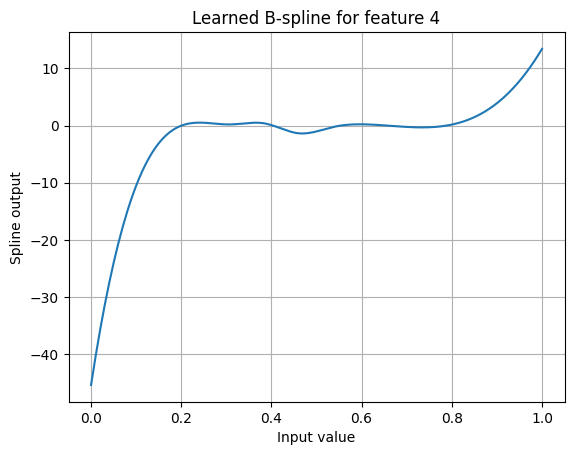

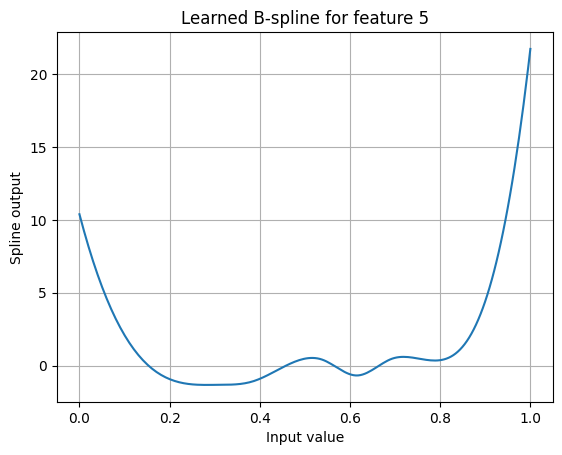

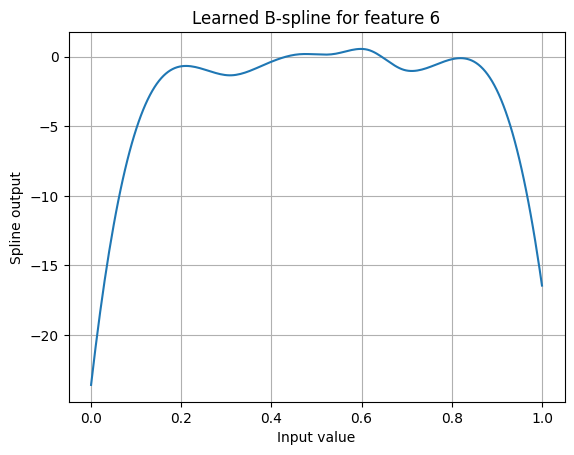

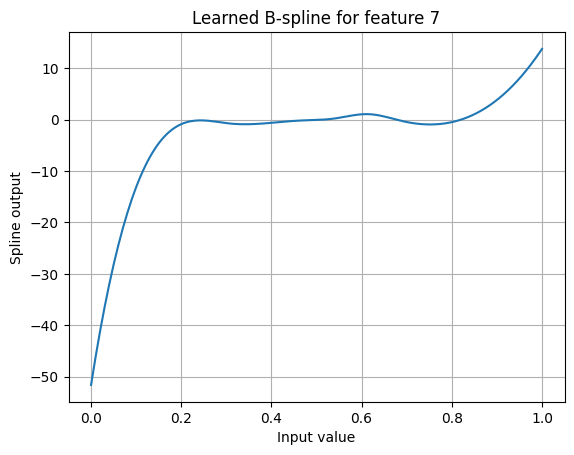

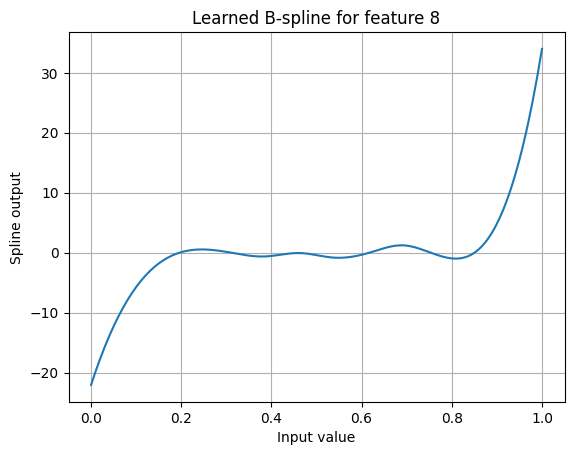

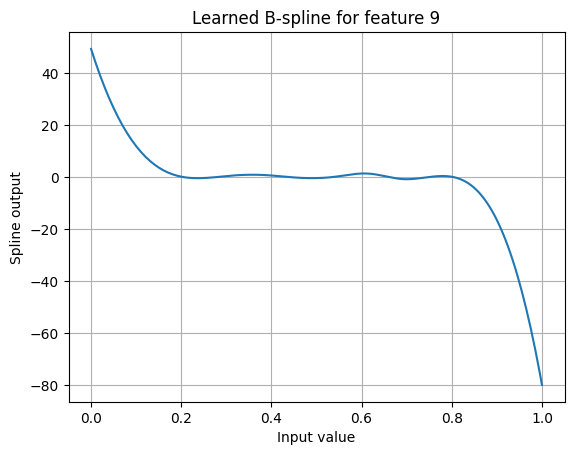

In [42]:
from scipy.interpolate import BSpline

def plot_splines(layer, feature_idx=0):
    knots = layer.knots_buffer.cpu().numpy()
    coeffs = layer.coeffs[feature_idx].detach().cpu().numpy()

    spline = BSpline(knots, coeffs, layer.degree)
    
    xs = np.linspace(0, 1, 200)
    ys = spline(xs)

    plt.plot(xs, ys)
    plt.title(f"Learned B-spline for feature {feature_idx}")
    plt.xlabel("Input value")
    plt.ylabel("Spline output")
    plt.grid(True)
    plt.show()

for i in range(10):
    plot_splines(model.bkan, feature_idx=i)


## Quantum KAN

A major concern with classical KANs is computational efficiency. The activation functions are not able to be learned in parallel using GPUs, so MLPs still dominate deep learning. In the quantum architecture, we can try to compute multiple parameters in parallel, speeding up the training process of KANs and increasing their practicality. However, we would have to keep in mind the advantages of KANs, such as interpretability, to ensure they aren't cancelled out by the quantum architecture.

Firstly, we would need to encode the classical MNIST vectors into quantum states. There are already techniques on how to do that (e.g. angle encoding on every 2x2 set of pixels as used by Pennylane here https://pennylane.ai/qml/demos/tutorial_quanvolution#loading-of-the-mnist-dataset). This would ensure the quantum KAN operates on embedded data.

The b-splines could be replaced by quantum b-splines (https://arxiv.org/pdf/2303.05428). The spline itself would remain classical, but its coefficients would be parametrized and determined using a quantum algorithm such as HHL. The coefficients would need to be scaled between 0 and 1 due to the nature of quantum probabilities. This would be a hybrid approach to calculating the coefficients and ultimately applying them as the learned b-splines.

A potential fully quantum solution, inspired by (https://arxiv.org/pdf/2410.04435), involves representing both the neuron values and the activation functions as quantum circuits. This is done by converting them directly into quantum gates, completely replacing classical spines (unlike the hybrid approach above). Each neuron’s activation function would correspond to a small variational quantum circuit trained globally as a quantum network, enabling layer-wise quantum optimization. This is consistent with the idea of parallelizing the calculations, but since the intermediate outputs of each quantum layer can be measured, interpretability can be preserved. The quantum KAN could be trained as a hybrid classical-quantum optimization loop (e.g. parameter shift rule + gradient descent), or potentially via quantum gradient descent.
